<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Class" data-toc-modified-id="Neural-Network-Class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Class</a></span></li><li><span><a href="#QSAR-aquatic-toxicity-Data-Set" data-toc-modified-id="QSAR-aquatic-toxicity-Data-Set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>QSAR aquatic toxicity Data Set</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Check-In" data-toc-modified-id="Check-In-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check-In</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# Neural Network Class

* A3.2: *Added `A3grader.py` and additional requirements involving application of your `NeuralNetwork` class to a specific data set.*
* A3.1: *Added some details on specifications of required functions and many examples of running your implementation.*

You will define a new class named `NeuralNetwork` that constructs a neural network with any number of hidden layers.  To train the neural network, you will use our `optimizers.py` code. Use this updated version: [optimizers.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar).  Your class must implement at least the following functions. Lecture Notes 07 provide examples of some of the code in the section about using `Optimizers` on which you can base your implementation.

* `__init__(self, n_inputs, n_hiddens_list, n_outputs)`: 
* `__repr__(self):`
* `make_weights(self):` called from constructor `__init__`
* `initialize_weights(self):` called from constructor `__init__`
* `train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):` `method` can be 'sgd', 'adam', or 'scg'. Must first calculate standarization parameters, stored in `stand_params` dictionary, and standardize `X` and `T`.  Import `optimizers.py` and use these optimizers in this `train` function. Use the `tanh` activation function.
* `use(self, X, return_hidden_layer_outputs=False):` standardizes X then calculates the output of the network by calling `forward` and unstandardizing the network output. Returns just the output of the last layer. If `return_hidden_layer_outputs` is `True`, return two things, the output of the last layer and a list of outputs from each hidden layer.
* `get_error_trace(self):` just returns the `error_trace`

In [157]:
import optimizers as opt

class NeuralNetwork():
    
    def __init__(self, n_inputs, n_hiddens_list, n_outputs):
        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(n_hiddens_list) + 1
        
        self.all_weights, self.Ws = self.make_weights()
        self.all_gradients, self.Gs = self.make_weights()
        self.initialize_weights()   
               
    def __repr__(self):
        return f'NeuralNetwork(n_inputs={self.n_inputs}, n_hiddens_list={self.n_hiddens_list}, n_outputs={self.n_outputs})'

    def make_weights(self):
        shape_tracker = []
        Ws = []
        n_weights = 0

        #Create all weights w/ proper sizing

        #Input
        mem_input = (1 + self.n_inputs)*self.n_hiddens_list[0]
        shape_tracker.append(mem_input)
        n_weights += mem_input
        #print("Input shape:" + str(mem_input))

        for i in range(1, len(self.n_hiddens_list)):
            mem_hidden = (self.n_hiddens_list[i - 1] + 1)*self.n_hiddens_list[i]
            shape_tracker.append(mem_hidden)
            n_weights += mem_hidden     
            #print("Hidden " + str(i) + " shape:" + str(mem_hidden))

        #Output
        mem_output = (self.n_hiddens_list[-1] + 1) * self.n_outputs
        shape_tracker.append(mem_output)
        n_weights += mem_output
        #print("Output shape:" + str(mem_output))

        # print("Total n_weights: " + str(n_weights))
        # print("Shape tracker: \n")
        # print(shape_tracker)
        
        all_weights = np.zeros(n_weights)
        
        #Create view into memory
        #Input 
        index = mem_input
        Ws.append(all_weights[:shape_tracker[0]].reshape(1 + self.n_inputs, self.n_hiddens_list[0]))
        # Ws[0][:] = 4
        # print("Input all weights")
        # print(all_weights)


        #Hidden
        prev_end = 0
        for i in range(1, len(self.n_hiddens_list)):
            if(prev_end == 0):
                prev_end = shape_tracker[i - 1]
            start_index = prev_end
            end_index = start_index + shape_tracker[i]
            prev_end = end_index
            Ws.append(all_weights[start_index:end_index].reshape(1 + self.n_hiddens_list[i - 1], self.n_hiddens_list[i]))
            # Ws[i][:] = 4 + i
            # print("Hidden layer " + str(i) + " all weights")
            # print(all_weights)

        #Output
        start_index = len(all_weights) - shape_tracker[-1]
        end_index = len(all_weights)
        Ws.append(all_weights[start_index:end_index].reshape(1 + self.n_hiddens_list[-1], self.n_outputs))
        # Ws[-1][:] = 999
        # print(Ws[-1])
        # print("Output all weights")
        # print(all_weights)

        return all_weights, Ws

    def initialize_weights(self):
        for i in range(len(self.Ws)):
            if(i == 0): 
                self.Ws[i][:] = np.random.uniform(-1, 1, size=(self.Ws[i].shape)) / np.sqrt(self.n_inputs + 1)
                #print(self.Ws[i])
            else:
                self.Ws[i][:] = np.random.uniform(-1, 1, size=(self.Ws[i].shape)) / np.sqrt(self.n_hiddens_list[i - 1] + 1)
                #print(self.Ws[i])

                
    def train(self, X, T, n_epochs, learning_rate, method, verbose=True):

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)

        def mse(Xst, Tst):
            Yst = self.forward(Xst)
            error = Tst - Yst[-1]
            return np.mean((error)**2)
            
        # Store standardization parameters in dictionary stand_parms.
        self.stand_params = self.calc_standardize_parameters(X, T)

        # Standardize X and T.
        Xst = self.standardize_X(X, self.stand_params)
        Tst = self.standardize_T(T, self.stand_params)

        optimizer = opt.Optimizers(self.all_weights)
        
        if method == 'sgd':
            self.error_trace = optimizer.sgd(mse, self.backward, [Xst, Tst], n_epochs, learning_rate, error_convert_f = error_convert, verbose=verbose)
        elif method == 'adam':
            self.error_trace = optimizer.adam(mse, self.backward, [Xst, Tst], n_epochs, learning_rate, error_convert_f = error_convert, verbose=verbose)
        elif method == 'scg':
            self.error_trace = optimizer.scg(mse, self.backward, [Xst, Tst], n_epochs, learning_rate, error_convert_f = error_convert, verbose=verbose)
        else:
            print('method must be ''sgd'', ''adam'', or ''scg''.')
                
        return self.stand_params, self.error_trace

    def forward(self, Xst):
        layers_final = []
        
        #Input layer 
        Z_input = np.tanh(add_ones(Xst) @ self.Ws[0])
        layers_final.append(Z_input)
        
        #All but the output layer (no activation function)
        for i in range(1, len(self.Ws) - 1):
            Z = np.tanh(add_ones(layers_final[i - 1]) @ self.Ws[i])
            layers_final.append(Z)
        
        #Output layer
        Yst = add_ones(layers_final[-1]) @ self.Ws[-1]
        layers_final.append(Yst)
        
        return layers_final

    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]
        n_outputs = Tst.shape[1]
        gradient_list = []
        
        # Init forward values
        outputs = self.forward(Xst)
        
        # Init Delta
        delta = -(Tst - outputs[-1]) /  (n_samples * n_outputs)
        
        # Back-propagate the delta value from the output layer, through the output layer weights,
        # to the hidden units.  Multiply the result by the derivative of the hidden units'
        # activation function, tanh
        self.Ws.reverse()
        outputs.reverse()
        self.Gs.reverse()
        for i in range(len(self.Ws)):
            # Output Layer
            if i == 0:
                self.Gs[i][:] = 2*(add_ones(outputs[i + 1]).T @ delta)
            # Hidden Layer(s)
            elif i != len(self.Ws) - 1:  
                delta = (delta @ self.Ws[i - 1][1:, :].T) * (1 - outputs[i] ** 2)
                self.Gs[i][:] = 2*(add_ones(outputs[i + 1]).T @ delta)
            # Input Layer
            else:
                delta = (delta @ self.Ws[i - 1][1:, :].T) * (1 - outputs[i] ** 2)
                self.Gs[i][:] = 2*(add_ones(Xst).T @ delta)
        
        self.Ws.reverse()
        self.Gs.reverse()
        return self.all_gradients
    
    def use(self, X, return_hidden_layer_outputs=False):
        # Standardize inputs X
        Xst = self.standardize_X(X, self.stand_params)
        # Calculate outputs of each layer.
        Yst = self.forward(Xst)
        # Unstandardize output of output layer
        Yst[-1] = self.unstandardize_T(Yst[-1], self.stand_params)
        
        if(return_hidden_layer_outputs):
            return Yst[-1], Yst[:-1]
        else:
            return Yst[-1]

    def get_error_trace(self):
        return self.error_trace

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds,
                'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X, stand_parms):
        return (X - stand_parms['Xmeans']) / stand_parms['Xstds']


    def unstandardize_X(self, Xst, stand_parms):
        return Xst * stand_parms['Xstds'] + stand_parms['Xmeans']


    def standardize_T(self, T, stand_parms):
        return (T - stand_parms['Tmeans']) / stand_parms['Tstds']


    def unstandardize_T(self, Tst, stand_parms):
        return Tst * stand_parms['Tstds'] + stand_parms['Tmeans']

#Outside NN class functions
def add_ones(X):
    return np.insert(X, 0, 1, axis=1)

Here are some example uses of your `NeuralNetwork` class.  Your implementation should return very close to the same values in each code cell.

In [158]:
import numpy as np
import matplotlib.pyplot as plt

In [159]:
np.random.seed(123)
nnet = NeuralNetwork(1, [3], 2)  # 2 outputs
nnet                                 

NeuralNetwork(n_inputs=1, n_hiddens_list=[3], n_outputs=2)

In [160]:
nnet.all_weights

array([ 0.27784939, -0.30244465, -0.38629038,  0.07257004,  0.31037599,
       -0.10874389,  0.4807642 ,  0.18482974, -0.0190681 , -0.10788248,
       -0.15682198,  0.22904971, -0.06142776, -0.4403221 ])

In [161]:
nnet.Ws

[array([[ 0.27784939, -0.30244465, -0.38629038],
        [ 0.07257004,  0.31037599, -0.10874389]]),
 array([[ 0.4807642 ,  0.18482974],
        [-0.0190681 , -0.10788248],
        [-0.15682198,  0.22904971],
        [-0.06142776, -0.4403221 ]])]

In [162]:
nnet.all_gradients

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [163]:
nnet.Gs

[array([[0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [164]:
X = np.linspace(-1, 1, 4).reshape(-1, 1)
X

array([[-1.        ],
       [-0.33333333],
       [ 0.33333333],
       [ 1.        ]])

In [165]:
T = np.hstack((X ** 2, (X - 2) ** 3))
T

array([[  1.        , -27.        ],
       [  0.11111111, -12.7037037 ],
       [  0.11111111,  -4.62962963],
       [  1.        ,  -1.        ]])

In [166]:
nnet.train(X, T, 5, 0.01, method='adam')

Adam: Epoch 1 Error=1.04625
Adam: Epoch 2 Error=1.03472
Adam: Epoch 3 Error=1.02343
Adam: Epoch 4 Error=1.01223
Adam: Epoch 5 Error=1.00111


({'Xmeans': array([-5.55111512e-17]),
  'Xstds': array([0.74535599]),
  'Tmeans': array([  0.55555556, -11.33333333]),
  'Tstds': array([0.44444444, 9.98799004])},
 [1.046252745686667,
  1.0347196138595187,
  1.0234280115224064,
  1.0122313682158668,
  1.0011130457971062])

In [11]:
nnet.stand_params

{'Xmeans': array([-5.55111512e-17]),
 'Xstds': array([0.74535599]),
 'Tmeans': array([  0.55555556, -11.33333333]),
 'Tstds': array([0.44444444, 9.98799004])}

In [12]:
nnet.Ws

[array([[ 0.32805608, -0.25283708, -0.33680913],
        [ 0.02237977,  0.36049588, -0.15868899]]),
 array([[ 0.43097923,  0.13534218],
        [-0.06903616, -0.15739467],
        [-0.10716161,  0.27902101],
        [-0.01180827, -0.44858975]])]

In [13]:
nnet.get_error_trace()

[1.046252745686667,
 1.0347196144715591,
 1.0234280127291415,
 1.0122313701179575,
 1.0011130484470065]

In [14]:
nnet.use(X)

array([[  0.76872931, -11.6317466 ],
       [  0.75768846, -10.39370636],
       [  0.74348724,  -9.01615621],
       [  0.72838516,  -7.64787949]])

In [619]:
Y, Zs = nnet.use(X, return_hidden_layer_outputs=True)
Y, Zs  # Zs is list of hidden layer output matrices

(array([[  0.76872931, -11.6317466 ],
        [  0.75768846, -10.39370636],
        [  0.74348724,  -9.01615621],
        [  0.72838516,  -7.64787949]]),
 [array([[ 0.28950918, -0.62702167, -0.1232753 ],
         [ 0.30774043, -0.39191093, -0.2597509 ],
         [ 0.32574847, -0.09136293, -0.38658353],
         [ 0.34352322,  0.22680527, -0.50030489]])])

Now here is a function you may use to train a `NeuralNetwork` using a particular method and values for the number of epochs and learning rate.

In [167]:
def run(method, n_epochs, learning_rate=0):
    
    n_samples = 30
    Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    ploti = 0

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
    plt.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    plt.plot(X_for_plot, Y, label='Neural Net Output')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')

    for layeri in range(nnet.n_layers - 2, -1, -1):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X_for_plot, Zs[layeri])
        plt.xlabel('X')
        plt.ylabel(f'Outputs from Layer {layeri}')
        
    return nnet

Method: sgd, RMSE: Train 0.13 Test 0.29


NeuralNetwork(n_inputs=1, n_hiddens_list=[50, 20, 20], n_outputs=1)

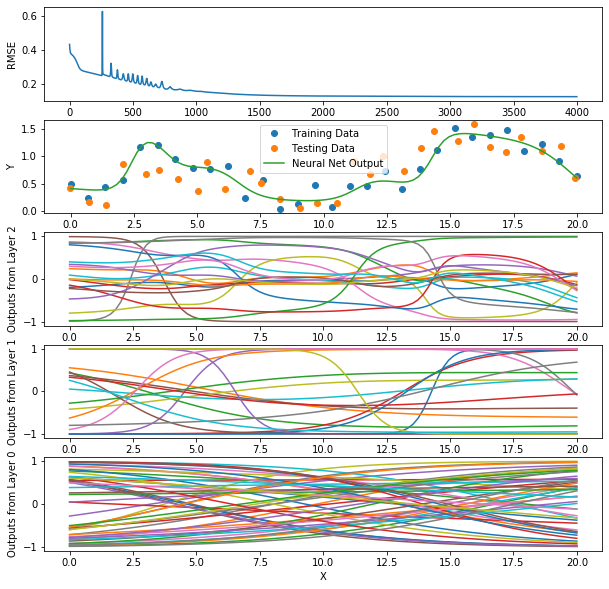

In [168]:
run('sgd', 4000, 0.1)

Method: adam, RMSE: Train 0.07 Test 0.26


NeuralNetwork(n_inputs=1, n_hiddens_list=[50, 20, 20], n_outputs=1)

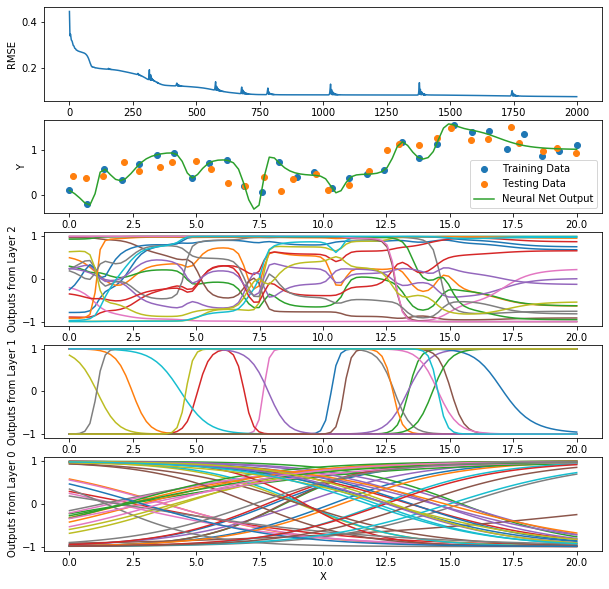

In [169]:
run('adam', 2000, 0.01)

Method: scg, RMSE: Train 0.00 Test 0.32


NeuralNetwork(n_inputs=1, n_hiddens_list=[50, 20, 20], n_outputs=1)

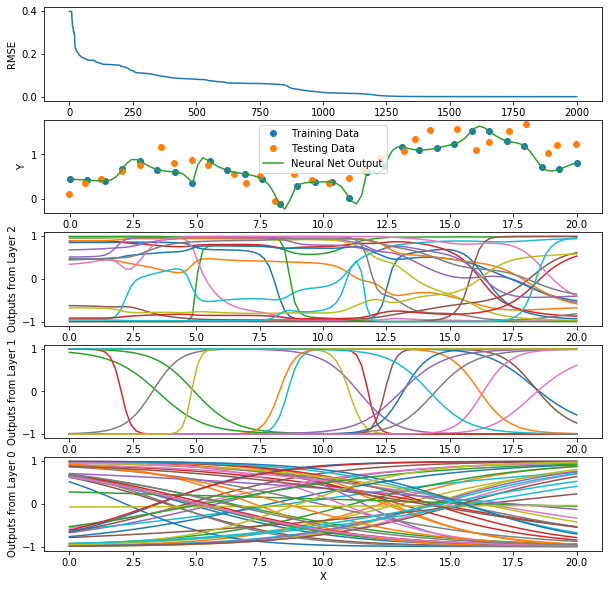

In [170]:
run('scg', 2000)

#  QSAR aquatic toxicity Data Set

Download the QSAR data set from [this UCI ML Repository site](https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity). It consists of eight measurements of water quality that may affect a ninth measurement, of aquatic toxicity towards [Daphnia Magna](https://en.wikipedia.org/wiki/Daphnia_magna#:~:text=Daphnia%20magna%20is%20a%20small,Northern%20Hemisphere%20and%20South%20Africa.).

Your job is to
* read this data into a numpy array,
* randomly shuffle the order of the rows in this data array (`np.random.shuffle`)
* take the first 500 rows as training data and the remaining rows as testing data,
* assign the first eight columns to `Xtrain` and `Xtest`, and the last column to `Ttrain` and `Ttest`,
* do some experimentation with different values of `n_hiddens_list`, `n_epochs` and `learning_rate` for the `sgd` and `adam` methods, and with different values of `n_hiddens_list`, `n_epochs` for `scg`, which does not use the `learning_rate`.
* using the parameter values (`n_epochs` and `learning_rate`) that you find produce the lowest RMSE on test data for each method, create plots for each method that include the `error_trace`, the training data targets and predictions by the neural network, and the testing data targets and predictions by the neural network. The differrent methods may use different parameter values.

Describe your results with at least 10 sentences.

In [69]:
import pandas as pd

#Import as Pandas Dataframe
headers = ["TPSA", "SAcc", "H-050", "MLOGP", "RDCHI", "GATS1p", "nN", "C-040", "LC-50"]
aqua_df = pd.read_csv("qsar_aquatic_toxicity.csv", delimiter=';', names=headers)
aqua_df



,TPSA,SAcc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040,LC-50
0,0.00,0.000,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
...,...,...,...,...,...,...,...,...,...
541,24.06,35.776,2,3.326,2.837,0.849,2,0,4.651
542,9.23,11.000,0,3.275,2.727,0.874,0,0,3.953
543,0.00,0.000,0,5.165,3.111,0.732,0,0,6.219
544,13.14,9.507,0,2.859,2.614,0.827,0,0,4.995


In [75]:
#Convert to numpy array and shuffle
np.random.seed(123)
aqua_np = aqua_df.to_numpy()
np.random.shuffle(aqua_np)
aqua_np


array([[  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   6.281],
       [ 45.82 ,  50.747,   0.   , ...,   1.   ,   0.   ,   4.268],
       [ 86.81 , 121.412,   3.   , ...,   2.   ,   0.   ,   2.958],
       ...,
       [ 20.23 ,  42.683,   1.   , ...,   0.   ,   0.   ,   3.85 ],
       [ 20.23 ,  42.683,   1.   , ...,   0.   ,   0.   ,   3.002],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   6.67 ]])

In [107]:
#Train/test split
Xtrain = aqua_np[:500, :8]
Xtest = aqua_np[500:, :8]

print(Xtrain.shape)
print(Xtest.shape)

Ttrain = aqua_np[:500, 8]
Ttest = aqua_np[500:, 8]

Ttrain = Ttrain.reshape(Ttrain.shape[0], 1)
Ttest = Ttest.reshape(Ttest.shape[0], 1)

print(Ttrain.shape)
print(Ttest.shape)

(500, 8)
(46, 8)
(500, 1)
(46, 1)


In [188]:
def run_aqua(Xtrain, Ttrain, Xtest, Ttest, method, n_epochs, learning_rate=0, verbose=False, plot=False, n_hiddens_list = [50,20,20]):

    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=verbose)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')
    if(plot):
        plt.figure(1, figsize=(20, 20))
        plt.clf()

        n_plot_rows = nnet.n_layers + 1
        ploti = 0

        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(nnet.get_error_trace())
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')

        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(Ttrain, 'o', label='Ttrain')
        plt.plot(Ytrain, label='Predicted Ttrain')
        plt.xlabel("Index")
        plt.ylabel("LC-50")

        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(Ttest, 'o', label='Ttest')
        plt.plot(Ytest, label='Predicted Ttrain')
        plt.xlabel("Index")
        plt.ylabel("LC-50")

        plt.legend()
        
    return nnet, rmse_test

In [176]:
model_info = []
for i in range(1, 10):
    print("Epochs: " + str(i * 1000))
    print("Learning rate: " + str (1 / (i * 10)))

    sgd = run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'sgd', i * 1000, 1 / (i * 10))
    adam = run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'adam', i * 1000, 1 / (i * 10))
    scg = run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'scg', i * 1000, 1 / (i * 10))

    model_info.append((sgd, adam, scg))
    print("\n")

Epochs: 1000
Learning rate: 0.1
Method: sgd, RMSE: Train 0.88 Test 1.25
Method: adam, RMSE: Train 0.34 Test 1.62
Method: scg, RMSE: Train 0.22 Test 1.92


Epochs: 2000
Learning rate: 0.05
Method: sgd, RMSE: Train 0.83 Test 1.37
Method: adam, RMSE: Train 0.11 Test 1.30
Method: scg, RMSE: Train 0.12 Test 1.94


Epochs: 3000
Learning rate: 0.03333333333333333
Method: sgd, RMSE: Train 0.79 Test 1.33
Method: adam, RMSE: Train 0.11 Test 1.92
Method: scg, RMSE: Train 0.10 Test 3.23


Epochs: 4000
Learning rate: 0.025
Method: sgd, RMSE: Train 0.81 Test 1.32
Method: adam, RMSE: Train 0.12 Test 1.49
Method: scg, RMSE: Train 0.10 Test 3.01


Epochs: 5000
Learning rate: 0.02
Method: sgd, RMSE: Train 0.76 Test 1.22
Method: adam, RMSE: Train 0.09 Test 1.85
Method: scg, RMSE: Train 0.07 Test 3.19


Epochs: 6000
Learning rate: 0.016666666666666666
Method: sgd, RMSE: Train 0.79 Test 1.36
Method: adam, RMSE: Train 0.09 Test 1.76
Method: scg, RMSE: Train 0.05 Test 3.51


Epochs: 7000
Learning rate: 0.014

After examining the output of the 9 training cycles above with increasing n_epochs and decrasing learning rate, it appears that a pattern of overfitting is emerging. As the number of epochs increases, so does the test error. This is slightly mitigated by the inversely decreasing learning rate, as shown in the later iterations. After training each model, we can examine the best model from each respective optimizer by comparing RMSE values for each parameter.

In [185]:
best_sgd = 1000
best_adam = 1000
best_scg = 1000

for t in model_info:
    sgd_rmse = t[0][1]
    adam_rmse = t[1][1]
    scg_rmse = t[2][1]

    if(sgd_rmse < best_sgd):
        best_sgd = sgd_rmse
    if(adam_rmse < best_adam):
        best_adam = adam_rmse
    if(scg_rmse < best_scg):
        best_scg = scg_rmse

print("Best SGD: " + str(best_sgd))
print("Best ADAM: " + str(best_adam))
print("Best SCG: " + str(best_scg))


Best SGD: 1.2194307880496975
Best ADAM: 1.301032820774844
Best SCG: 1.9182160714299952


Using the training parameters above for each optimizer as a baseline, we can now vary the structure of the network to (hopefully) gain even more accuracy on the testing set.

In [189]:
hiddens_info = []
for i in range(1, 10):
    hiddens_list = [i, i *10, i * 6]
    print("Hiddens List: "+ str(hiddens_list))

    sgd = run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'sgd', 5000, 0.02, n_hiddens_list=hiddens_list)
    adam = run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'adam', 2000, 0.05,  n_hiddens_list=hiddens_list)
    scg = run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'scg', 1000, 0.1,  n_hiddens_list=hiddens_list)

    hiddens_info.append((sgd, adam, scg))
    print("\n")

Hiddens List: [1, 10, 6]
Method: sgd, RMSE: Train 1.18 Test 1.26
Method: adam, RMSE: Train 1.12 Test 1.19
Method: scg, RMSE: Train 1.11 Test 1.17


Hiddens List: [2, 20, 12]
Method: sgd, RMSE: Train 1.11 Test 1.17
Method: adam, RMSE: Train 0.86 Test 1.48
Method: scg, RMSE: Train 0.98 Test 1.27


Hiddens List: [3, 30, 18]
Method: sgd, RMSE: Train 1.08 Test 1.20
Method: adam, RMSE: Train 0.44 Test 1.74
Method: scg, RMSE: Train 0.77 Test 1.70


Hiddens List: [4, 40, 24]
Method: sgd, RMSE: Train 1.00 Test 1.22
Method: adam, RMSE: Train 0.36 Test 1.59
Method: scg, RMSE: Train 0.49 Test 1.91


Hiddens List: [5, 50, 30]
Method: sgd, RMSE: Train 0.96 Test 1.21
Method: adam, RMSE: Train 0.26 Test 1.61
Method: scg, RMSE: Train 0.38 Test 1.54


Hiddens List: [6, 60, 36]
Method: sgd, RMSE: Train 1.00 Test 1.26
Method: adam, RMSE: Train 0.15 Test 1.66
Method: scg, RMSE: Train 0.33 Test 2.03


Hiddens List: [7, 70, 42]
Method: sgd, RMSE: Train 0.96 Test 1.31
Method: adam, RMSE: Train 0.15 Test 1.86


In [192]:
for t in hiddens_info:
    sgd_rmse = t[0][1]
    adam_rmse = t[1][1]
    scg_rmse = t[2][1]

    if(sgd_rmse < best_sgd):
        best_sgd = sgd_rmse
    if(adam_rmse < best_adam):
        best_adam = adam_rmse
    if(scg_rmse < best_scg):
        best_scg = scg_rmse

print("Best SGD: " + str(best_sgd))
print("Best ADAM: " + str(best_adam))
print("Best SCG: " + str(best_scg))

Best SGD: 1.1694922507455299
Best ADAM: 1.1913276676330573
Best SCG: 1.16619764982146


Hoorah! We saw a significant decrease in the errors of all three optimizers. While some of the decrease could be explained by better random weights at initalization, certainly differences this large indicate that a varied structure saw better results on the test set. Most notable however, are the markedly lower training accuracies displayed at each iteration. Even though these training accuracies are significantly lower than those of the previous, more dense structure, the testing accuracies are higher because the model isn't overfitting as severely. 

It also worth noting that SCG saw a reduction in error more than 2 times as large as the other optimizers, where it's most succesfull architecture was the simplest of all! We can plot the RMSE, and predictions to confirm these findings on all three optimizers.

Method: sgd, RMSE: Train 1.11 Test 1.16


(NeuralNetwork(n_inputs=8, n_hiddens_list=[2, 20, 12], n_outputs=1),
 1.158308236186441)

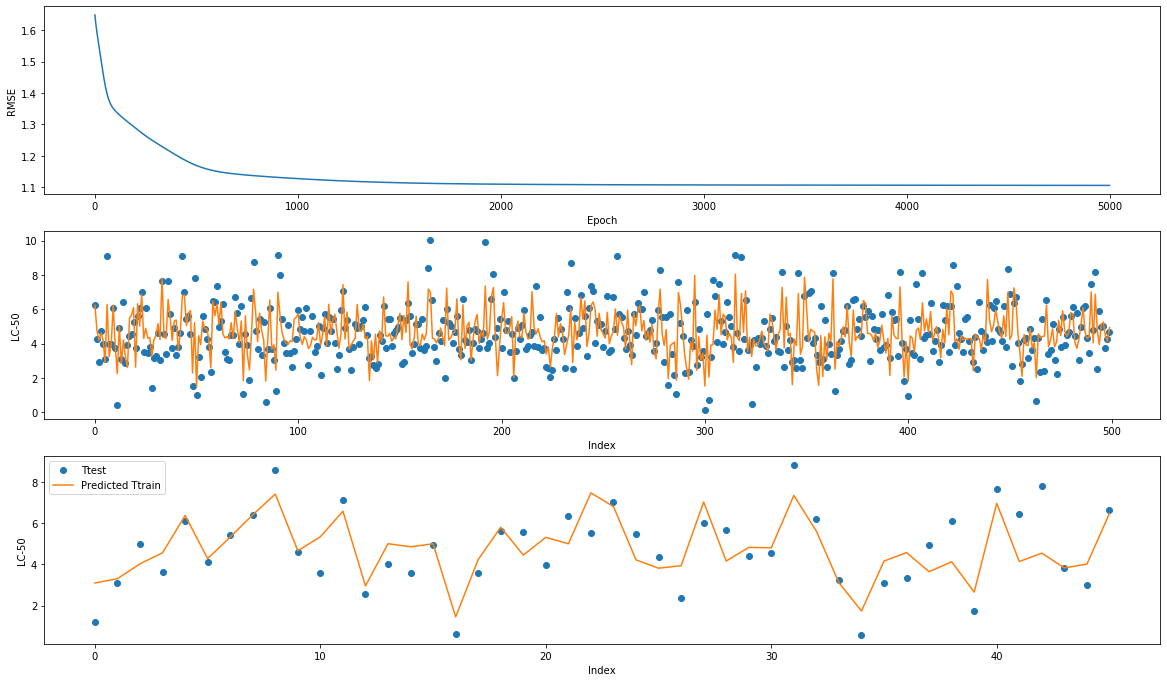

In [193]:
run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'sgd', 5000, 0.02, n_hiddens_list=[2,20,12], plot = True)

Method: adam, RMSE: Train 1.21 Test 1.25


(NeuralNetwork(n_inputs=8, n_hiddens_list=[1, 10, 6], n_outputs=1),
 1.2531051681157537)

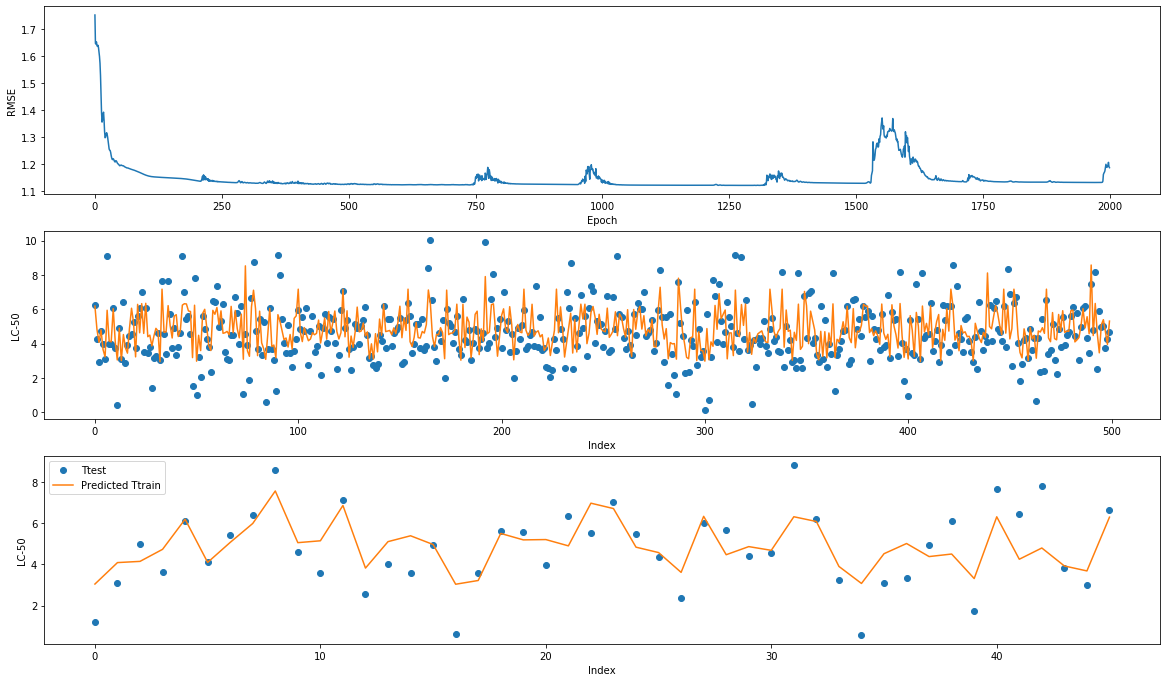

In [194]:
run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'adam', 2000, 0.05, n_hiddens_list=[1, 10, 6], plot = True)

Method: scg, RMSE: Train 1.10 Test 1.17


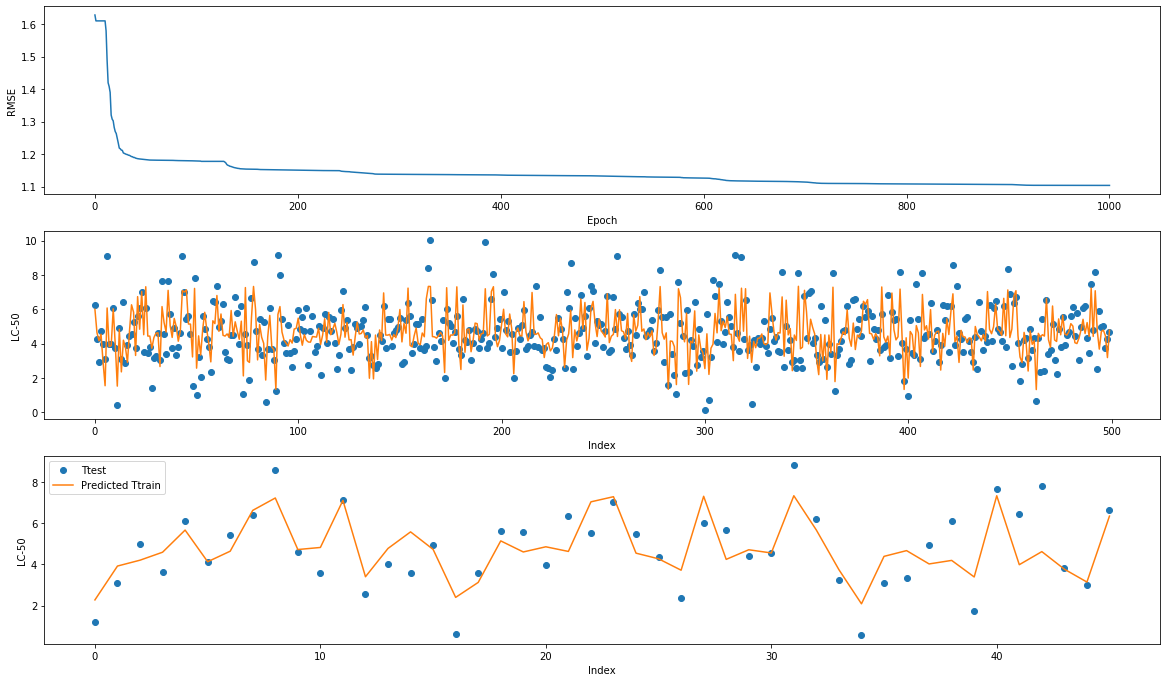

In [195]:
scg = run_aqua(Xtrain, Ttrain, Xtest, Ttest, 'scg', 1000, 0.1,  n_hiddens_list=[1, 10, 6], plot = True)

Naturally, we still see some variation in the repeat training call due to the random weights. Overall however, it can be noted that these three models performed the best on the testing set out of all the experiments. Overfitting was abundantly clear in the first model set which used a dense network. Re-calculation of model parameters to find those most optimal for the given optimizer architecture would likely yield even better results.

In [196]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Ridgeway-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'NeuralNetworks' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetwork(2, [5, 4], 3)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    nnet.Ws[0][2, 0] = 100.0
    # Does nnet.Ws[0][2, 0] == nnet.all_weights[10]


--